# Deep Learning with PyTorch : Build an AutoEncoder

An autoencoder is a type of neural network that learns to copy its input to its output. In autoencoder, encoder encodes the image into compressed representation, and the decoder decodes the representation.

![](denoising_autoencoder.png)

Applications of AutoEncoder:

- Segmentation
- Denoising Image
- Super Resolution Image
- Image Compression
- and many more .....

In this Project, you will see the simplest implemention of autoencoder for image denoising task.

In [2]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from tqdm.notebook import tqdm 

ModuleNotFoundError: No module named 'matplotlib'

# Exploring Dataset 

In [2]:
data = pd.read_csv("mnist_dataset.csv")
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
image = data.iloc[7] # selecting image at index 7 
image = np.array(image).astype('float32')
image = np.reshape(image,(28,28)) # reshaping image to 28 x 28 
image = image / 255 # to scale image between 0 to 1

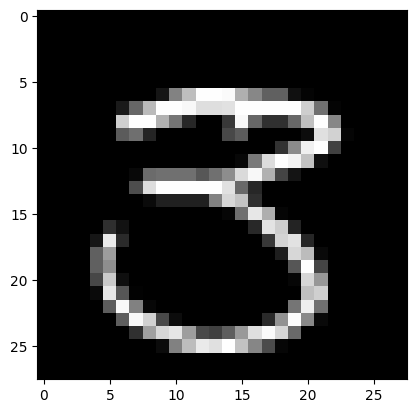

In [4]:
plt.imshow(image,cmap = "gray") 

In [5]:
noisy_image = image + 0.2 * np.random.randn(*image.shape) # Adding random noise to image 
noisy_image = np.clip(noisy_image,0,1) #ranging between 0 - 1

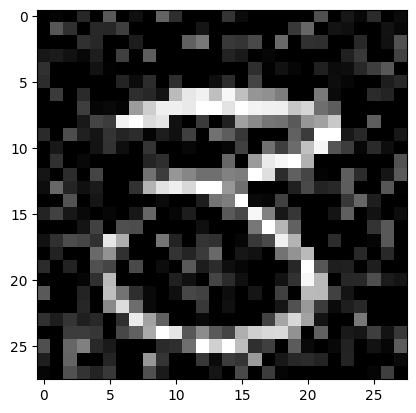

In [6]:
plt.imshow(noisy_image,cmap = "gray")

# Data Preparation 

In [7]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

<img src="dataset.png" alt="drawing" width="400"/>

In [ ]:
class MNIST_AE_Dataset(Dataset):
    
    def __init__(self,csv_file,noise_factor = 0.2,transform = None):
        
        self.data = pd.read_csv(csv_file)
        self.transform = transform 
        self.noise_factor = noise_factor
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        
        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img,(28,28,1)) / 255
        
        noisy_img = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_img = np.clip(noisy_img,0.,1.)
        
        sample = (noisy_img,img)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

### **Here to ToTensorForAE() is a function which will convert numpy,PIL image to torch tensor and also it will convert image with (height,width,channel) to (channel,height,width) as per the pytorch model input convention.**

For eg, numpy array image with shape (28,28,1) will be first converted to image torch tensor with shape(28,28,1)
and then the channel is shifted to 0th axis so image tensor will be with shape (1,28,28)

In [ ]:
trainset = MNIST_AE_Dataset('mnist_dataset.csv',transform = ToTensorForAE())

In [ ]:
print("Size of trainset : {}".format(len(trainset)))

In [ ]:
noisy_image,org_image = trainset[6]
noisy_image.shape

In [ ]:
show_image(noisy_image,org_image) 

# Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader 

In [ ]:
trainloader = DataLoader(trainset,batch_size = 16,shuffle = True)

In [ ]:
dataiter = iter(trainloader)
noisy_image, org_image = dataiter.next()

print("Shape of loading one batch : {}".format(noisy_image.shape))
print("Shape of loading one batch : {}".format(org_image.shape))

print("Total no. of batches present in trainloader : {}".format(len(trainloader))) #total no. of batches
print("Total no. of examples present in trainloader : {}".format(len(trainloader.dataset)))

# Question 6
#len(trainset) and len(trainloader.dataset), both gives total no. of examples present in the dataset. TRUE

#Question 5
#Suppose use have a dataset in which input images (X) are black and white image and original images or ground truth images (Y)  are color image. 
#Can we use Autoencoder here for image colorization ?

# Create AutoEncoder Model

In [ ]:
import torch
from torch import nn 
from torchsummary import summary

In [ ]:
def Encoder():
    
    enc = nn.Sequential(
        
        nn.Conv2d(in_channels = 1, out_channels = 16,kernel_size = (3,3),padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2)), 
        nn.Conv2d(in_channels = 16, out_channels = 32,kernel_size = (3,3),padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2))
    )
    
    return enc

In [ ]:
def Decoder():
    
    dec = nn.Sequential(
        
        nn.ConvTranspose2d(in_channels = 32,out_channels = 16,kernel_size = (2,2),stride = 2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels = 16,out_channels = 1,kernel_size = (2,2),stride = 2),
        nn.Sigmoid()
    )
    
    return dec

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        
        self.encoder = Encoder()
        self.decoder = Decoder()


    def forward(self, x):
       
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder()
model

In [ ]:
summary(model,input_size = (1,28,28))

# Train AutoEncoder Model 

In [ ]:
from torch import optim
from tqdm import tqdm 

In [ ]:
optimizer = optim.Adam(model.parameters(),lr = 0.001)
criterion = nn.MSELoss()
epochs = 5

In [ ]:
for i in range(epochs):
    
    train_loss = 0.0
    
    for noisy_image,image in tqdm(trainloader):
        
        optimizer.zero_grad()
        pred_image = model(noisy_image)
        loss = criterion(pred_image,image)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    print("Epoch : {} Train Loss : {}".format(i+1,train_loss/len(trainloader)))

# Plot Results

In [ ]:
model.eval()

with torch.no_grad():
    
    dataiter = iter(trainloader)
    sample = dataiter.next()
    
    noisy_image,image = sample
    
    index = 0 
    
    pred_image = model(noisy_image[index].unsqueeze(0))
    print(pred_image.squeeze(0).shape)
    show_image(noisy_image[index],image[index],pred_image.squeeze(0))